# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

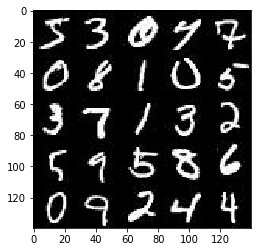

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

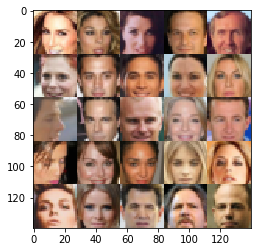

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\Users\Andreas\AppData\Local\conda\conda\envs\dl\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
        
    inputs_real   = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def default_gan_activation(x,alpha=0.2):
    #return tf.nn.elu(x)
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator_valid_padding(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 6, strides=2, padding='valid')
        relu1 = default_gan_activation(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 4, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = default_gan_activation(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = default_gan_activation(bn3)
        
        relu3_size = int(relu3.shape[1]*relu3.shape[2]*relu3.shape[3])

        flat = tf.reshape(relu3, (-1, relu3_size))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator_valid_padding, tf)

Tests Passed


In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    x = images
    d = 0
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.layers.dropout(x1,d)
        relu1 = default_gan_activation(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.dropout(x2,d)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = default_gan_activation(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.dropout(x3,d)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = default_gan_activation(bn3)
        
        relu3_size = int(relu3.shape[1]*relu3.shape[2]*relu3.shape[3])

        flat = tf.reshape(relu3, (-1, relu3_size))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator_valid_padding(z, out_channel_dim, is_train=True,debug = False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if(debug):
        print('-----verify generator inputs:-----')
        [print(i) for i in zip(['z', 'out_channel_dim', 'is_train'],[z, out_channel_dim, is_train])]
    
    # TODO: Implement Function
    (z, output_dim, reuse, training) = (z, out_channel_dim, not(is_train), is_train)
    
    default_padding = 'same'
    default_kernel_size = 5

    with tf.variable_scope('generator', reuse=reuse):
        a=2
        x1 = tf.layers.dense(z, a*a*512)
        x1 = tf.reshape(x1, (-1, a, a, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = default_gan_activation(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = default_gan_activation(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = default_gan_activation(x3)
        
        logits = tf.layers.conv2d_transpose(x3, output_dim, 6, strides=2,  padding='valid')
        
        out = tf.tanh(logits)
        
        if(debug):
            print('-----verify generator processing:-----')
            [print(i) for i in zip(['x1','x2','x3'],[x1,x2,x3])]
            
            print('-----verify generator outputs:-----')
            print(out)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator_valid_padding, tf)

Tests Passed


In [10]:
def generator(z, out_channel_dim, is_train=True,debug = False):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    if(debug):
        print('-----verify generator inputs:-----')
        [print(i) for i in zip(['z', 'out_channel_dim', 'is_train'],[z, out_channel_dim, is_train])]
    
    # TODO: Implement Function
    (z, output_dim, reuse, training) = (z, out_channel_dim, not(is_train), is_train)
    
    default_padding = 'same'
    default_kernel_size = 5

    with tf.variable_scope('generator', reuse=reuse):
        a=2
        x1 = tf.layers.dense(z, a*a*512)
        x1 = tf.reshape(x1, (-1, a, a, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = default_gan_activation(x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, default_kernel_size, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = default_gan_activation(x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, default_kernel_size, strides=2, padding=default_padding)
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = default_gan_activation(x3)
        
        logits = tf.layers.conv2d_transpose(x3, output_dim, default_kernel_size, strides=2, padding=default_padding)
        
        out = tf.tanh(logits)
        
        if(debug):
            print('-----verify generator processing:-----')
            [print(i) for i in zip(['x1','x2','x3'],[x1,x2,x3])]
            
            print('-----verify generator outputs:-----')
            print(out)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_dim = out_channel_dim

    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smoothing = 1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print('-----verify train inputs:-----')
    [print(i) for i in zip(['epoch_count', 'batch_size', 'z_dim', 'learning_rate', 'beta1', 'get_batches', 'data_shape', 'data_image_mode'],\
                           [epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode])]
    
    
    print_every = max(batch_size//16,10)
    show_every  = print_every*10
    n_images = show_n_images
    
    filename_suffix = '_' + data_image_mode + '_' + str(z_dim)
    saver_path  = './checkpoints_generator'+filename_suffix+'.ckpt'
    sample_path = './samples'+filename_suffix+'.pkl'
    
    tf.reset_default_graph()

    # MODEL  INPUT
    input_real, input_z, input_learning_rate =  model_inputs(*data_shape[1:], z_dim)

    # MODEL
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('variables initialized')
        saver = tf.train.Saver()
        
        try:
            saver.restore(sess, saver_path)
            print('variables restored')
        except:
            pass
        
        steps = 1
        samples, losses = [], []
        for e in range(epoch_count):
            #for x, y in dataset.batches(batch_size):
            for batch_x in get_batches(min(steps,batch_size)): ## incriasing batchsize to optimise trainingspeed (and time) over iterations, partly simular to a learning rate declay
                steps += 1
                #print(steps,end='')

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) 
                batch_x *= 2

                # Run optimizers
                for _ in range(1):
                    _ = sess.run(d_train_opt, feed_dict={input_real         : batch_x,
                                                         input_z            : batch_z,
                                                         input_learning_rate: learning_rate})
                
                for _ in range(3):
                    _ = sess.run(g_train_opt, feed_dict={input_real         : batch_x,
                                                         input_z            : batch_z,
                                                         input_learning_rate: learning_rate})
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_x})
                    train_loss_g = g_loss.eval({input_z: batch_z})
 
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
 
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[-1], data_image_mode)
 
                    saver.save(sess, saver_path)

    with open(sample_path, 'wb') as f:
        pkl.dump(samples, f)
    
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

    return losses, samples


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

-----verify train inputs:-----
('epoch_count', 2)
('batch_size', 64)
('z_dim', 100)
('learning_rate', 0.0002)
('beta1', 0.5)
('get_batches', <bound method Dataset.get_batches of <helper.Dataset object at 0x000002ECED7D7630>>)
('data_shape', (60000, 28, 28, 1))
('data_image_mode', 'L')
variables initialized
variables restored
Epoch 1/2... Discriminator Loss: 0.4460... Generator Loss: 1.3485
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 1.1816
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 0.8147
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 0.5527... Generator Loss: 1.0867
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 0.3945... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 0.2316... Generator Loss: 1.9002


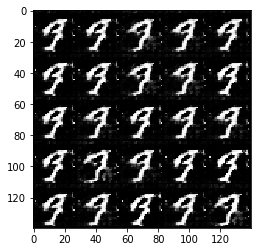

Epoch 1/2... Discriminator Loss: 0.2582... Generator Loss: 1.6952
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 1.6519
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 0.8715
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 1.4844
Epoch 1/2... Discriminator Loss: 0.2201... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 0.5183... Generator Loss: 1.1318
Epoch 1/2... Discriminator Loss: 0.1344... Generator Loss: 2.2027
Epoch 1/2... Discriminator Loss: 0.2128... Generator Loss: 1.7603
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.6491
Epoch 1/2... Discriminator Loss: 0.8356... Generator Loss: 0.8932


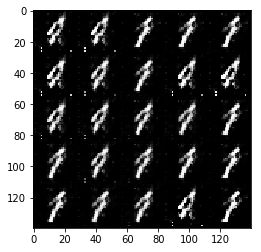

Epoch 1/2... Discriminator Loss: 0.3958... Generator Loss: 1.5585
Epoch 1/2... Discriminator Loss: 0.5801... Generator Loss: 1.1614
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.7229
Epoch 1/2... Discriminator Loss: 0.7335... Generator Loss: 0.7751
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 0.2204... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 0.5450... Generator Loss: 1.1360
Epoch 1/2... Discriminator Loss: 1.8619... Generator Loss: 0.3574
Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 0.7899... Generator Loss: 0.6889


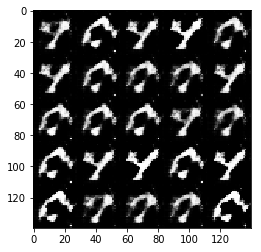

Epoch 1/2... Discriminator Loss: 0.4411... Generator Loss: 1.6165
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.3327... Generator Loss: 1.5242
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 0.5755... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 0.9368
Epoch 1/2... Discriminator Loss: 0.9782... Generator Loss: 0.9018
Epoch 1/2... Discriminator Loss: 0.7383... Generator Loss: 1.2219
Epoch 1/2... Discriminator Loss: 0.4999... Generator Loss: 1.2672
Epoch 1/2... Discriminator Loss: 0.5176... Generator Loss: 1.0058


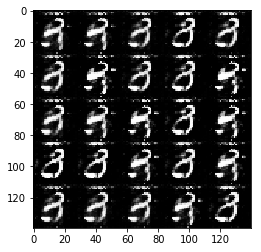

Epoch 1/2... Discriminator Loss: 0.3284... Generator Loss: 1.5936
Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 0.3304... Generator Loss: 1.8545
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 0.5871
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 0.3258... Generator Loss: 1.2929
Epoch 1/2... Discriminator Loss: 0.3922... Generator Loss: 1.7230
Epoch 1/2... Discriminator Loss: 0.1248... Generator Loss: 2.1741
Epoch 1/2... Discriminator Loss: 0.3111... Generator Loss: 1.4019
Epoch 1/2... Discriminator Loss: 0.2229... Generator Loss: 1.7852


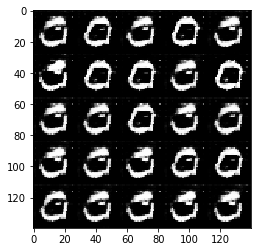

Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 1.8656
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 1.2969
Epoch 1/2... Discriminator Loss: 0.5873... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 0.3664... Generator Loss: 1.5741
Epoch 1/2... Discriminator Loss: 0.2276... Generator Loss: 1.7721
Epoch 1/2... Discriminator Loss: 0.4694... Generator Loss: 1.2540
Epoch 1/2... Discriminator Loss: 0.6662... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.3860... Generator Loss: 1.3536


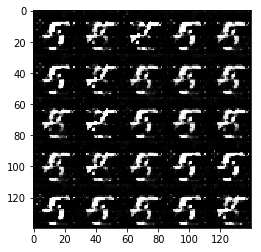

Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 0.7203
Epoch 1/2... Discriminator Loss: 0.3464... Generator Loss: 1.6634
Epoch 1/2... Discriminator Loss: 0.1844... Generator Loss: 1.8245
Epoch 1/2... Discriminator Loss: 1.9195... Generator Loss: 0.3035
Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 1.1138... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 0.2895... Generator Loss: 1.3945
Epoch 1/2... Discriminator Loss: 0.4755... Generator Loss: 1.3775
Epoch 1/2... Discriminator Loss: 0.3964... Generator Loss: 1.3681
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.1277


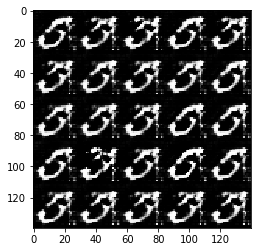

Epoch 1/2... Discriminator Loss: 0.4073... Generator Loss: 1.2676
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.6955
Epoch 1/2... Discriminator Loss: 0.6634... Generator Loss: 1.2271
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 0.5355... Generator Loss: 1.2869
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 0.3435... Generator Loss: 1.4711
Epoch 1/2... Discriminator Loss: 0.5451... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 0.4188... Generator Loss: 1.2521
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 0.8686


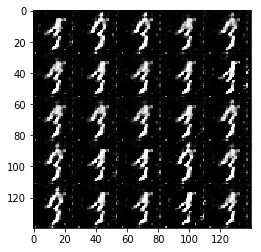

Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.0378
Epoch 1/2... Discriminator Loss: 1.8289... Generator Loss: 0.5607
Epoch 1/2... Discriminator Loss: 0.4271... Generator Loss: 1.1081
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 0.6271
Epoch 1/2... Discriminator Loss: 0.3250... Generator Loss: 1.6777
Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 0.5670... Generator Loss: 0.9150
Epoch 1/2... Discriminator Loss: 0.6917... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 0.2531... Generator Loss: 1.7433


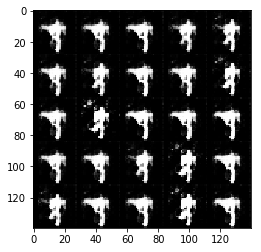

Epoch 1/2... Discriminator Loss: 0.3878... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 1.2448
Epoch 1/2... Discriminator Loss: 0.5537... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.5816... Generator Loss: 0.9263
Epoch 1/2... Discriminator Loss: 0.4481... Generator Loss: 1.5903
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 1.0985
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 0.4235... Generator Loss: 1.5561
Epoch 1/2... Discriminator Loss: 0.6021... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 0.4885... Generator Loss: 1.2401


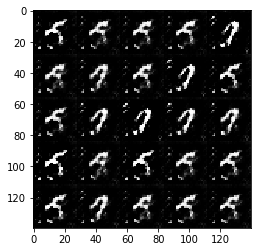

Epoch 1/2... Discriminator Loss: 0.7092... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 0.2941... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 0.6656... Generator Loss: 1.4945
Epoch 1/2... Discriminator Loss: 0.7323... Generator Loss: 0.7202
Epoch 1/2... Discriminator Loss: 0.5358... Generator Loss: 1.0973
Epoch 1/2... Discriminator Loss: 0.8389... Generator Loss: 1.2926
Epoch 1/2... Discriminator Loss: 2.4662... Generator Loss: 1.1720


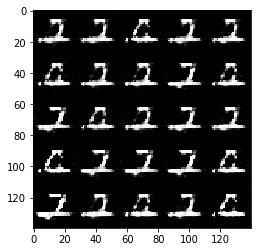

Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.8497
Epoch 1/2... Discriminator Loss: 0.8980... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 1.1451
Epoch 1/2... Discriminator Loss: 0.1846... Generator Loss: 1.9701
Epoch 1/2... Discriminator Loss: 0.4466... Generator Loss: 1.6173
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7808
Epoch 1/2... Discriminator Loss: 1.7853... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.1837
Epoch 1/2... Discriminator Loss: 0.2971... Generator Loss: 1.7829


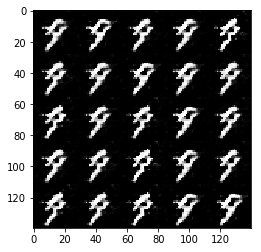

Epoch 1/2... Discriminator Loss: 0.5114... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.7570... Generator Loss: 0.9061
Epoch 1/2... Discriminator Loss: 0.1559... Generator Loss: 2.1220
Epoch 1/2... Discriminator Loss: 0.3404... Generator Loss: 1.3612


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 =  .5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

-----verify train inputs:-----
('epoch_count', 1)
('batch_size', 64)
('z_dim', 100)
('learning_rate', 0.0002)
('beta1', 0.5)
('get_batches', <bound method Dataset.get_batches of <helper.Dataset object at 0x0000023D861E1F98>>)
('data_shape', (202599, 28, 28, 3))
('data_image_mode', 'RGB')
variables initialized
variables restored
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 0.1687... Generator Loss: 1.9035
Epoch 1/1... Discriminator Loss: 0.2816... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 0.1509... Generator Loss: 2.0611
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 1.6052
Epoch 1/1... Discriminator Loss: 0.1468... Generator Loss: 2.0200
Epoch 1/1... Discriminator Loss: 0.2414... Generator Loss: 1.6707
Epoch 1/1... Discriminator Loss: 0.2588... Generator Loss: 2.2352
Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 2.2712


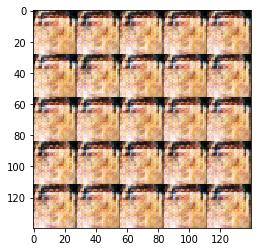

Epoch 1/1... Discriminator Loss: 0.1821... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 1.8430
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 1.2829
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 2.0225
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.4970
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 0.2394... Generator Loss: 1.6307
Epoch 1/1... Discriminator Loss: 0.1699... Generator Loss: 1.8683
Epoch 1/1... Discriminator Loss: 0.4371... Generator Loss: 1.0871


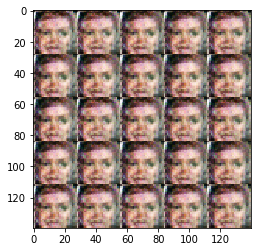

Epoch 1/1... Discriminator Loss: 0.4553... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 0.3013... Generator Loss: 1.5197
Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 1.8837
Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 0.1634... Generator Loss: 2.0791
Epoch 1/1... Discriminator Loss: 0.1391... Generator Loss: 2.1667
Epoch 1/1... Discriminator Loss: 0.0922... Generator Loss: 2.5403
Epoch 1/1... Discriminator Loss: 0.1007... Generator Loss: 2.4312
Epoch 1/1... Discriminator Loss: 0.2860... Generator Loss: 1.8082
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 0.7287


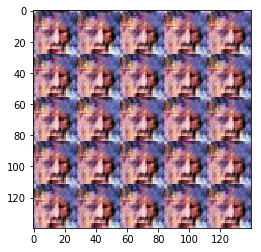

Epoch 1/1... Discriminator Loss: 0.6012... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 0.8484... Generator Loss: 0.9753
Epoch 1/1... Discriminator Loss: 0.2486... Generator Loss: 1.6346
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 1.4324
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.1009
Epoch 1/1... Discriminator Loss: 0.2832... Generator Loss: 1.4285
Epoch 1/1... Discriminator Loss: 0.1598... Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 0.1481... Generator Loss: 2.1794
Epoch 1/1... Discriminator Loss: 0.3689... Generator Loss: 1.5479
Epoch 1/1... Discriminator Loss: 0.2103... Generator Loss: 1.8145


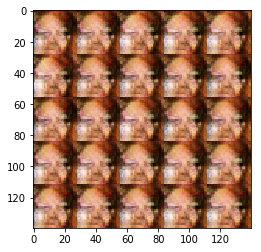

Epoch 1/1... Discriminator Loss: 0.2870... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 1.8159
Epoch 1/1... Discriminator Loss: 0.5200... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 0.1679... Generator Loss: 2.0981
Epoch 1/1... Discriminator Loss: 0.1750... Generator Loss: 1.8421
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 1.8297
Epoch 1/1... Discriminator Loss: 0.3063... Generator Loss: 1.9070
Epoch 1/1... Discriminator Loss: 0.3512... Generator Loss: 1.8703
Epoch 1/1... Discriminator Loss: 0.3882... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.1144... Generator Loss: 2.3543


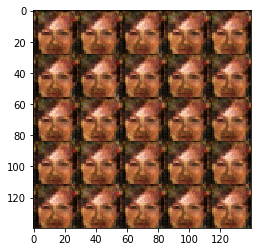

Epoch 1/1... Discriminator Loss: 0.1932... Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 0.3295... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 0.1250... Generator Loss: 2.2928
Epoch 1/1... Discriminator Loss: 0.3444... Generator Loss: 1.8160
Epoch 1/1... Discriminator Loss: 0.4024... Generator Loss: 1.1517
Epoch 1/1... Discriminator Loss: 0.5302... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.6922


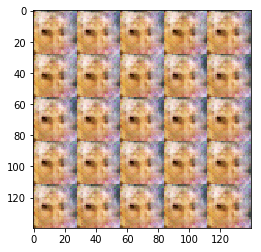

Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 0.5888... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 2.5527... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 1.9028
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.3124
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 0.4665... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 0.5247... Generator Loss: 1.5541
Epoch 1/1... Discriminator Loss: 0.2855... Generator Loss: 1.8940


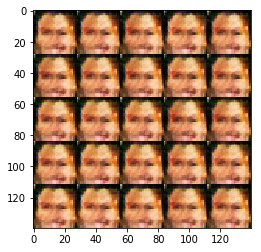

Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.3849... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 2.2654
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.2348
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 1.9710
Epoch 1/1... Discriminator Loss: 0.3097... Generator Loss: 1.3917
Epoch 1/1... Discriminator Loss: 0.1562... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 1.8542
Epoch 1/1... Discriminator Loss: 0.1670... Generator Loss: 1.8925


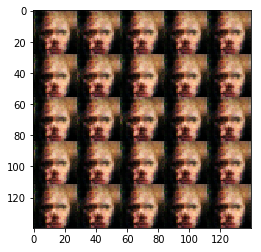

Epoch 1/1... Discriminator Loss: 0.1428... Generator Loss: 2.0209
Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 2.8229
Epoch 1/1... Discriminator Loss: 0.1319... Generator Loss: 2.2032
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.2686... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 0.2356... Generator Loss: 1.6141
Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 1.8756
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 1.6624


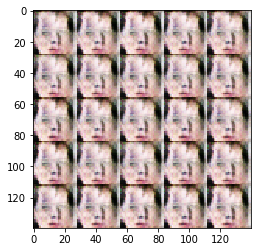

Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 1.7312
Epoch 1/1... Discriminator Loss: 0.1755... Generator Loss: 2.0011
Epoch 1/1... Discriminator Loss: 0.2453... Generator Loss: 1.7064
Epoch 1/1... Discriminator Loss: 0.6094... Generator Loss: 1.3533
Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 1.7822
Epoch 1/1... Discriminator Loss: 0.2684... Generator Loss: 1.8796
Epoch 1/1... Discriminator Loss: 0.1223... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.2409... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.1548... Generator Loss: 1.9973
Epoch 1/1... Discriminator Loss: 0.4578... Generator Loss: 1.4322


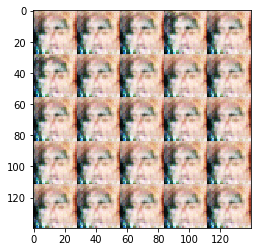

Epoch 1/1... Discriminator Loss: 0.3866... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 0.2435... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 1.3619
Epoch 1/1... Discriminator Loss: 0.5143... Generator Loss: 1.0753
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.3094... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.2558... Generator Loss: 1.5755
Epoch 1/1... Discriminator Loss: 0.4273... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.8027


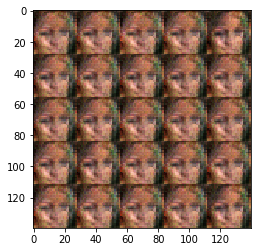

Epoch 1/1... Discriminator Loss: 0.5755... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 0.4816... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 0.1969... Generator Loss: 1.7421
Epoch 1/1... Discriminator Loss: 0.3997... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.1117... Generator Loss: 2.2697
Epoch 1/1... Discriminator Loss: 0.7157... Generator Loss: 1.0107


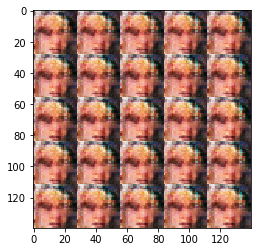

Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 0.2448... Generator Loss: 1.8588
Epoch 1/1... Discriminator Loss: 0.2309... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.1327... Generator Loss: 2.1306
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.0691... Generator Loss: 2.7632
Epoch 1/1... Discriminator Loss: 0.0791... Generator Loss: 2.6261
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 2.5296


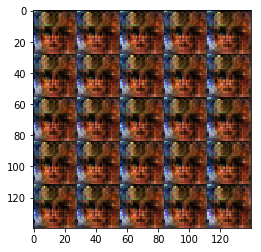

Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 0.2113... Generator Loss: 1.6700
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 0.2564... Generator Loss: 1.5452
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.2743... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.3389... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 0.3246... Generator Loss: 1.4739


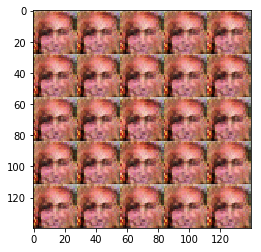

Epoch 1/1... Discriminator Loss: 3.3733... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 2.3339... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 0.4885... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 1.7985
Epoch 1/1... Discriminator Loss: 0.3223... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 0.3728... Generator Loss: 1.6533
Epoch 1/1... Discriminator Loss: 0.2049... Generator Loss: 1.7096


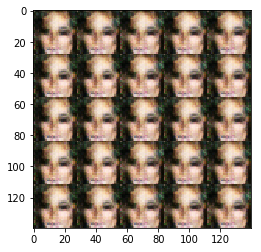

Epoch 1/1... Discriminator Loss: 3.7208... Generator Loss: 1.1653
Epoch 1/1... Discriminator Loss: 0.2266... Generator Loss: 1.7048
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 1.6632
Epoch 1/1... Discriminator Loss: 0.2527... Generator Loss: 1.5150
Epoch 1/1... Discriminator Loss: 1.7605... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 1.6647
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 0.1852... Generator Loss: 2.0802
Epoch 1/1... Discriminator Loss: 0.1553... Generator Loss: 1.9536


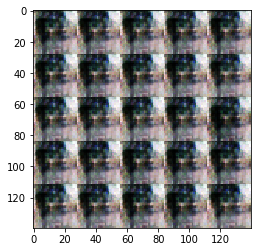

Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 2.0003
Epoch 1/1... Discriminator Loss: 0.1597... Generator Loss: 1.9269
Epoch 1/1... Discriminator Loss: 0.1657... Generator Loss: 1.8963
Epoch 1/1... Discriminator Loss: 0.3091... Generator Loss: 1.3367
Epoch 1/1... Discriminator Loss: 0.3451... Generator Loss: 1.5417
Epoch 1/1... Discriminator Loss: 0.4378... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 0.1028... Generator Loss: 2.3391
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 1.7767
Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 1.8371


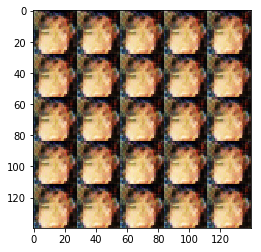

Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.4300... Generator Loss: 1.2551
Epoch 1/1... Discriminator Loss: 0.1497... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 0.2933... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 1.1788
Epoch 1/1... Discriminator Loss: 0.5137... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.3640... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 1.8722
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.0226


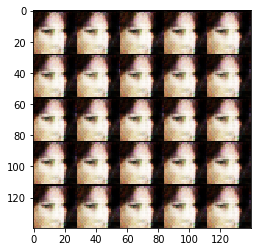

Epoch 1/1... Discriminator Loss: 0.0580... Generator Loss: 2.9442
Epoch 1/1... Discriminator Loss: 0.1043... Generator Loss: 2.3472
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.1225
Epoch 1/1... Discriminator Loss: 0.1682... Generator Loss: 1.9077
Epoch 1/1... Discriminator Loss: 0.4956... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 1.7921
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 1.0532
Epoch 1/1... Discriminator Loss: 0.3792... Generator Loss: 1.6489


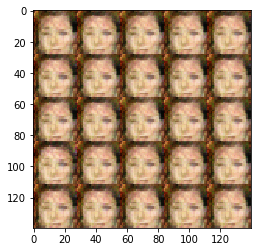

Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.5577... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 0.3810... Generator Loss: 1.1948
Epoch 1/1... Discriminator Loss: 0.6309... Generator Loss: 1.2978
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 3.6463... Generator Loss: 0.6332


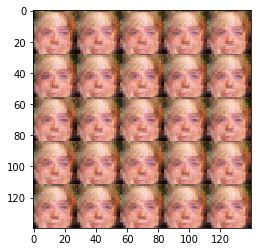

Epoch 1/1... Discriminator Loss: 0.4043... Generator Loss: 1.3720
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 2.0471... Generator Loss: 1.1538
Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 0.9778
Epoch 1/1... Discriminator Loss: 0.5895... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 2.2595
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 1.7020
Epoch 1/1... Discriminator Loss: 1.8576... Generator Loss: 1.2597


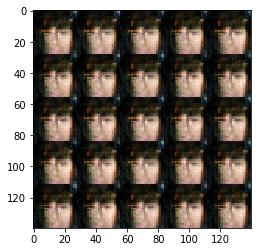

Epoch 1/1... Discriminator Loss: 0.2772... Generator Loss: 2.4328
Epoch 1/1... Discriminator Loss: 0.2111... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.3563... Generator Loss: 1.9554
Epoch 1/1... Discriminator Loss: 0.3013... Generator Loss: 1.5924
Epoch 1/1... Discriminator Loss: 0.1781... Generator Loss: 1.8267
Epoch 1/1... Discriminator Loss: 0.2472... Generator Loss: 1.5280
Epoch 1/1... Discriminator Loss: 0.2395... Generator Loss: 1.6371
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 2.5509
Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 2.9674
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 2.6552


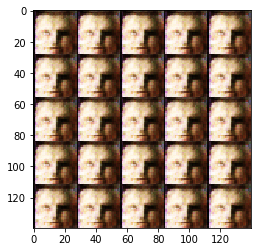

Epoch 1/1... Discriminator Loss: 0.0792... Generator Loss: 2.6663
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 1.6436
Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 2.0566
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.4379... Generator Loss: 1.1644


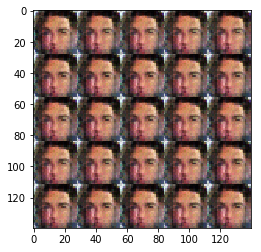

Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 1.8409
Epoch 1/1... Discriminator Loss: 0.2441... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.2999... Generator Loss: 1.6790


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 =  .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.